In [111]:
import pandas as pd
from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
import time
import swifter # For Parallel computing and use MultiThread 

from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy
import seaborn as sns
import matplotlib.pyplot as plt



In [5]:
df=pd.read_csv("C:/Users/pctes/Downloads/DANA_PROJECTS/DANA_4840/data_2.csv")
df_labels=pd.read_csv("C:/Users/pctes/Downloads/DANA_PROJECTS/DANA_4840/labels.csv")

In [62]:
df.tail()

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
796,sample_796,0.0,1.865642,2.718197,7.350099,10.006003,0.0,6.764792,0.496922,0.0,...,6.088133,9.118313,10.004852,4.484415,9.614701,12.031267,9.813063,10.092770,8.819269,0.000000
797,sample_797,0.0,3.942955,4.453807,6.346597,10.056868,0.0,7.320331,0.000000,0.0,...,6.371876,9.623335,9.823921,6.555327,9.064002,11.633422,10.317266,8.745983,9.659081,0.000000
798,sample_798,0.0,3.249582,3.707492,8.185901,9.504082,0.0,7.536589,1.811101,0.0,...,5.719386,8.610704,10.485517,3.589763,9.350636,12.180944,10.681194,9.466711,4.677458,0.586693
799,sample_799,0.0,2.590339,2.787976,7.318624,9.987136,0.0,9.213464,0.000000,0.0,...,5.785237,8.605387,11.004677,4.745888,9.626383,11.198279,10.335513,10.400581,5.718751,0.000000
800,sample_800,0.0,2.325242,3.805932,6.530246,9.560367,0.0,7.957027,0.000000,0.0,...,6.403075,8.594354,10.243079,9.139459,10.102934,11.641081,10.607358,9.844794,4.550716,0.000000


In [61]:
df_labels.tail()

,Unnamed: 0,Class
796,sample_796,BRCA
797,sample_797,LUAD
798,sample_798,COAD
799,sample_799,PRAD
800,sample_800,PRAD


In [70]:
# Let's check if both labels have the same names 
list_labels=df_labels.iloc[:,0].tolist()
list_df=df.iloc[:,0].tolist()
print((list_labels)==(list_df))

True


In [74]:
# Class column was sent to the end of the columns 
df_merged=df.merge(df_labels,on="Unnamed: 0",how="left")


In [79]:
column_list_df=df.columns.tolist()

In [80]:
# Now we are moving Class column to the first position 
df_merged=df_merged[["Class"] + column_list_df]

In [83]:
df_merged.head()

,Class,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,PRAD,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,LUAD,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,PRAD,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,PRAD,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,BRCA,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [82]:
# We are dropping the Unnamed column
df_merged.drop(columns=["Unnamed: 0"],inplace=True)

C:\Users\pctes\AppData\Local\Temp\ipykernel_20136\2789653522.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged.drop(columns=["Unnamed: 0"],inplace=True)


In [84]:
# Exploratory Data Analysis

df_merged_copy=df_merged.copy()


,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.0,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,3.010909,3.095350,6.722305,9.813612,0.0,7.405509,0.499882,0.016744,0.013428,...,5.896573,8.765891,10.056252,4.847727,9.741987,11.742228,10.155271,9.590726,5.528177,0.095411
std,0.136850,1.200828,1.065601,0.638819,0.506537,0.0,1.108237,0.508799,0.133635,0.204722,...,0.746399,0.603176,0.379278,2.382728,0.533898,0.670371,0.580569,0.563849,2.073859,0.364529
min,0.000000,0.000000,0.000000,5.009284,8.435999,0.0,3.930747,0.000000,0.000000,0.000000,...,2.853517,6.678368,8.669456,0.000000,7.974942,9.045255,7.530141,7.864533,0.593975,0.000000
25%,0.000000,2.299039,2.390365,6.303346,9.464466,0.0,6.676042,0.000000,0.000000,0.000000,...,5.454926,8.383834,9.826027,3.130750,9.400747,11.315857,9.836525,9.244219,4.092385,0.000000
50%,0.000000,3.143687,3.127006,6.655893,9.791599,0.0,7.450114,0.443076,0.000000,0.000000,...,5.972582,8.784144,10.066385,5.444935,9.784524,11.749802,10.191207,9.566511,5.218618,0.000000
75%,0.000000,3.883484,3.802534,7.038447,10.142324,0.0,8.121984,0.789354,0.000000,0.000000,...,6.411292,9.147136,10.299025,6.637412,10.082269,12.177852,10.578561,9.917888,6.876382,0.000000
max,1.482332,6.237034,6.063484,10.129528,11.355621,0.0,10.718190,2.779008,1.785592,4.067604,...,7.771054,11.105431,11.318243,9.207495,11.811632,13.715361,11.675653,12.813320,11.205836,5.254133


In [87]:
df_merged["Class"].unique()



array(['PRAD', 'LUAD', 'BRCA', 'KIRC', 'COAD'], dtype=object)

#### PRAD: PRAD stands for Prostate Adenocarcinoma. It refers to cancers that arise in the prostate gland.
#### LUAD: LUAD stands for Lung Adenocarcinoma. It refers to cancers that arise in the lung tissue.
#### BRCA: BRCA stands for Breast Cancer. Specifically, it refers to cancers that arise in breast tissue.
#### KIRC: KIRC stands for Kidney Renal Clear Cell Carcinoma. 
#### COAD: COAD stands for Colon Adenocarcinoma. It refers to cancers that arise in the colon.




In [58]:
#  Beginning of Exploratory Data Analysis
# There is only one Object Column ,the rest are numerical values
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20532 entries, Unnamed: 0 to gene_20530
dtypes: float64(20531), object(1)
memory usage: 125.5+ MB


In [95]:
# Let's see the distribution of the data across CLASS columns
df_merged.groupby("Class").size()

Class
BRCA    300
COAD     78
KIRC    146
LUAD    141
PRAD    136
dtype: int64

In [98]:
df_pivot=pd.pivot_table(df_merged,index=["Class"],aggfunc="mean")
df_pivot

# We are comparing the mean of all genes acros the classes to plot and compare any discrepancy 

,gene_0,gene_1,gene_10,gene_100,gene_1000,gene_10000,gene_10001,gene_10002,gene_10003,gene_10004,...,gene_9990,gene_9991,gene_9992,gene_9993,gene_9994,gene_9995,gene_9996,gene_9997,gene_9998,gene_9999
Class,,,,,,,,,,,,,,,,,,,,,
BRCA,0.011362,2.839739,0.544066,10.681488,10.303568,3.258028,7.339461,7.900497,7.489146,7.508378,...,1.969278,5.142237,1.736160,2.312551,1.696127,2.493789,0.046527,2.099709,0.151063,6.954733
COAD,0.022212,3.438381,0.357278,11.015745,9.951124,3.462039,5.526673,7.487396,3.783493,6.959238,...,2.216178,0.354828,1.833606,1.619692,3.839205,2.396207,0.090327,2.298246,0.065007,6.618466
KIRC,0.046544,2.398129,1.166824,10.238999,11.148094,1.651798,6.895752,7.686932,7.269611,7.636246,...,1.824964,0.596508,2.393303,1.872888,1.289448,3.139623,0.130416,2.387948,0.148641,6.429343
LUAD,0.041088,3.358260,0.607541,10.517670,10.503698,3.754181,7.281878,7.041924,6.145042,7.148682,...,2.609490,2.801700,2.738326,1.869805,2.217144,2.459608,0.042070,2.281828,0.056608,6.721517
PRAD,0.026544,3.441041,0.765608,10.282936,9.967433,1.949878,7.946141,8.529695,5.696368,7.396572,...,1.623491,4.594215,1.684084,2.588050,1.703772,3.568490,0.572893,3.621548,0.094953,7.104225


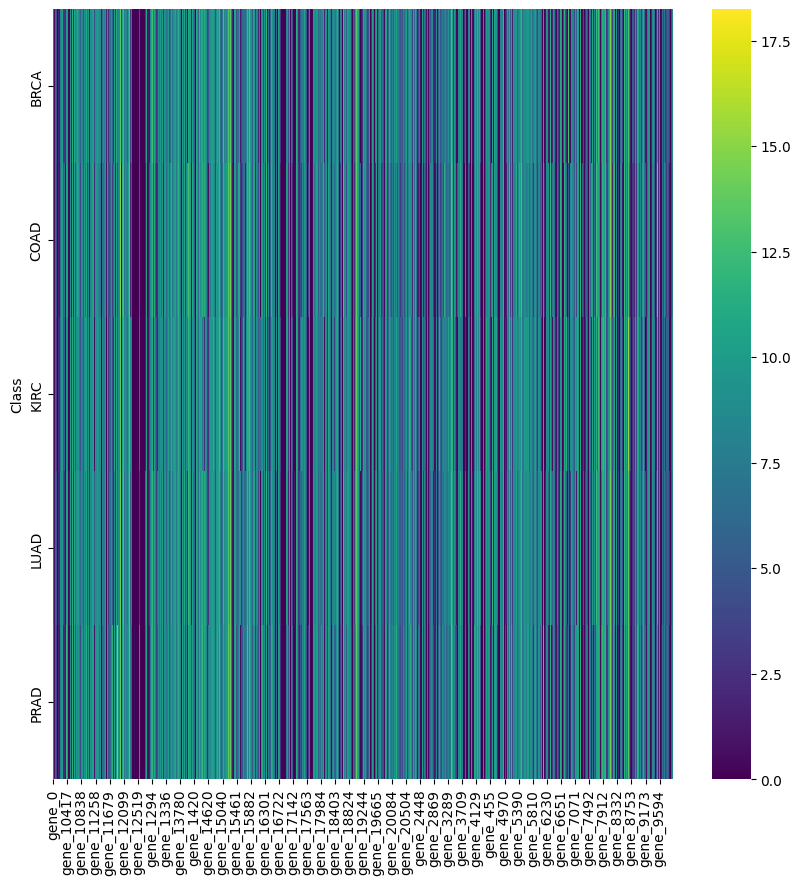

In [108]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import seaborn as sns

# I will use the pivot table to plot the heatmap
plt.figure(figsize=(10,10))
sns.heatmap(df_pivot,cmap="viridis")
plt.show()

In [112]:
# Compute the distance matrix
# 2min and 52 seconds
dist=df_merged.iloc[:,1:].T.corr()

In [113]:
df_numerical=df_merged.iloc[:,1:]

In [117]:
df_numerical.head(3)

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0


In [ ]:
# Let's scale the data before calculating the distances
scaler = StandardScaler()
scaled_data=scaler.fit_transform(df_numerical)

In [115]:
# Using parallel computing to compute the distance matrix , this is equivalent to R as dist(X,method = "euclidean")
from scipy.spatial.distance import pdist

def compute_distance(df):
    return pdist(df.T.corr().values)

# Using swift as parallel computing
dist = df_numerical.swifter.apply(compute_distance)


TypeError: Series.corr() missing 1 required positional argument: 'other'

In [48]:
# Scale the merged file 
scaler = StandardScaler()
scaled_data=scaler.fit_transform(df.iloc[:,1:])


In [50]:
df_scaled.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,-0.194799,-0.828030,0.159800,-1.948277,1.221575,0.0,-0.207968,0.180910,-0.125376,-0.065633,...,-1.300200,-0.921755,-0.877838,0.996247,-1.166072,0.389441,-0.869566,-1.187938,-0.116483,-0.261901
1,-0.194799,-2.015017,-1.415042,1.353109,-0.376518,0.0,-0.532222,-0.983088,-0.125376,-0.065633,...,-1.747076,-2.392213,-0.831893,0.591649,-2.549598,1.391628,0.623551,-0.342277,-1.656889,-0.261901
2,-0.194799,0.417348,1.156735,0.249807,0.112832,0.0,-0.391297,-0.092995,-0.125376,-0.065633,...,-1.034088,-1.059669,2.248803,0.232601,0.317880,-4.025621,-0.632381,0.886860,-1.855264,-0.261901
3,-0.194799,0.543888,1.326182,-0.099053,0.755741,0.0,0.395348,-0.127831,-0.125376,-0.065633,...,0.241299,0.044905,0.224956,1.719725,-0.263847,-0.521747,-0.793609,0.166174,-1.078941,-0.261901
4,-0.194799,-0.295955,-0.257107,-0.286413,-0.148843,0.0,-0.757118,-0.273165,-0.125376,-0.065633,...,0.133335,0.208252,0.837739,0.979924,0.196645,0.268992,-1.615841,-0.229878,-0.201588,-0.261901


In [56]:
# Labels  5 classes: BRCA, KIRC, COAD, LUAD, and PRAD
classes_labels=df_labels["Class"].unique().tolist()
print(classes_labels)

['PRAD', 'LUAD', 'BRCA', 'KIRC', 'COAD']


In [ ]:
# PCA
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(df_scaled)


In [57]:
# We will implement CLARA instead of K means to see the relationship between the variables

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


C:\Users\pctes\AppData\Local\Temp\ipykernel_20136\571717318.py:19: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_square, method='average')


<Figure size 1000x600 with 0 Axes>

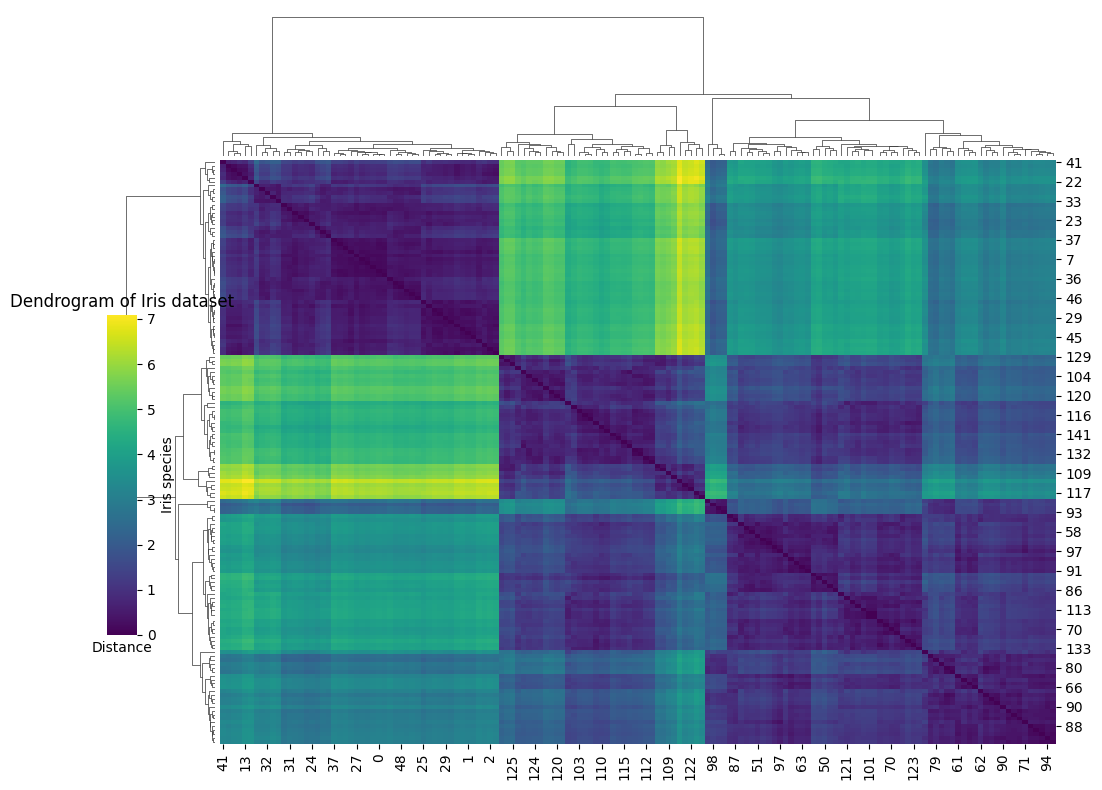

In [110]:

# We will implement CLARA instead of K means to see the relationship between the variables


